In [84]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import signal
import math
from tqdm import tqdm

# LBP: Local Binary Patterns

We try to extract binary patterns around a concerned pixel based whether neighbors are greater or smaller than a particular threshold. The threshold is usually the intensity value of the concerned pixel itself. These binary patterns provide us decimal numbers, whose frequencies are computed in a patch to form a hostogram for the patch. 

(600, 400)


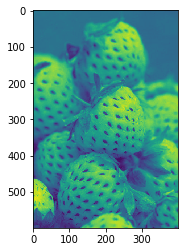

In [85]:
image = cv2.imread('straw.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
print(image.shape)
plt.imshow(image)
plt.show()

In [86]:
def calculateLbpPixel(image, x,y):
    
    centre = image[x,y]
    
    arr = []

    if(image[x-1,y-1] > centre):
        arr.append(1)
    else:
        arr.append(0)
        
    if(image[x-1,y] > centre):
        arr.append(1)
    else:
        arr.append(0)
        
    if(image[x-1,y+1] > centre):
        arr.append(1)
    else:
        arr.append(0)
        
    if(image[x,y+1] > centre):
        arr.append(1)
    else:
        arr.append(0)
        
    if(image[x+1,y+1] > centre):
        arr.append(1)
    else:
        arr.append(0)
        
    if(image[x+1,y] > centre):
        arr.append(1)
    else:
        arr.append(0)
        
    if(image[x+1,y-1] > centre):
        arr.append(1)
    else:
        arr.append(0)
        
    if(image[x,y-1] > centre):
        arr.append(1)
    else:
        arr.append(0)
    bits = [128,64,32,16,8,4,2,1]
    
    val = 0 
    
    for i in range(len(arr)):
        val+=arr[i]*bits[i]
    return val

In [87]:
print(calculateLbpPixel(image,52,200))

110


In [88]:
m,n = image.shape
pad_image = np.zeros((m+2,n+2))
pad_image[1:m+1, 1:n+1] = image
result = np.zeros((m,n))
for i in range(1, m+1):
    for j in range(1,n+1):
        result[i-1,j-1] = calculateLbpPixel(pad_image, i,j)

Image-Level LBP Feature


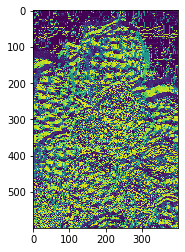

In [89]:
print("Image-Level LBP Feature")
plt.imshow(result)
plt.show()


# HOG: Histogram of Gradients
We compute gradient's magnitude and direction. <br>
Key angles are chosen (say 0,45,90,135,180,-135,-90,-45) to form bins for the hostogram. <br>
For a pixel in a patch, based on the proximity of the gradient's direction with the two key angles beetween which the dierection lies, its magnitude is shared by the bins of the two angles. <br>
When we share magnitudes of each pixel in the patch this way and acculmulate these magnitudes for the bins, the result is called HOG feature.  <br>

(600, 400)


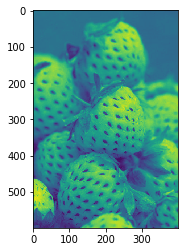

In [90]:
image = cv2.imread('straw.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
print(image.shape)
plt.imshow(image)
plt.show()

In [91]:
def get_gradients(image):
    sobel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_y = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    
    G_x = signal.convolve2d(image,sobel_x, "same")
    G_y = signal.convolve2d(image,sobel_y, "same")
    
    mag = (G_x**2 + G_y**2)**0.5
    theta = np.zeros((image.shape[0], image.shape[1]))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            x = G_x[i,j]
            y = G_y[i,j]
            
            if(x > 0):
                theta[i,j] = math.degrees(math.atan(y/x))
            elif(x < 0 and y >= 0):
                theta[i,j] = math.degrees(math.atan(y/x)) + 180
            elif(x < 0 and y < 0 ):
                theta[i,j] = math.degrees(math.atan(y/x)) - 180
            elif(x == 0 and y > 0 ):
                theta[i,j] = 90
            elif(x == 0 and y < 0):
                theta[i,j] = -90
            elif(x == 0 and y == 0):
                theta[i,j] = float('NaN')
            else:
                continue
    plt.imshow(G_x)
    plt.title("X gradient")
    plt.show()
    plt.imshow(G_y)
    plt.title("Y gradient")
    plt.show()
    return mag, theta
    

In [92]:
def HOG_cell_histogram(cell_direction, cell_magnitude, hist_bins):
    HOG_cell_hist = np.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    bins_gaps = abs(hist_bins[0] - hist_bins[1])
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
    
            diff = np.abs(curr_direction - hist_bins)
#             print(diff, np.where(diff == np.min(diff)))
            try : 
                min_idx = np.where(diff == np.min(diff))[0][0]

                if(min_idx == 0):
                    HOG_cell_hist[min_idx] += curr_magnitude

                elif(min_idx == hist_bins.size-1):
                    HOG_cell_hist[min_idx] += (abs(curr_direction - hist_bins[-1])/bins_gaps)*curr_magnitude
                    HOG_cell_hist[min_idx-1] += (abs(curr_direction - hist_bins[-2])/bins_gaps)*curr_magnitude
                else:
                    HOG_cell_hist[min_idx] += (abs(curr_direction - hist_bins[min_idx])/bins_gaps)*curr_magnitude
                    HOG_cell_hist[min_idx+1] += (abs(curr_direction - hist_bins[min_idx + 1])/bins_gaps)*curr_magnitude
            except:
                continue
           
    return HOG_cell_hist

In [93]:
def generate_HOG(mag, theta, image, patch_size = 8, plot = False):
        
    m,n = image.shape
    
    bins = np.array([-135, -90,-45, 0, 45, 90, 135, 180])
    HOG_hist = np.array([])
    
    for i in range(0,m, patch_size):
        for j in range(0,n, patch_size):
            
            curr_mag = mag[i : i+patch_size,j : j+patch_size]
            curr_direc = theta[i : i+patch_size,j : j+patch_size]
            bins = np.array([-135, -90,-45, 0, 45, 90, 135, 180])
            hist = HOG_cell_histogram(curr_direc, curr_mag, bins)
            if(plot):
                fig = plt.figure(figsize = (2,2))
                ax = fig.add_axes([0,0,1,1])
                x_axis = ["-135", "-90","-45", "0", "45", "90", "135", "180"]
                ax.bar(x_axis,hist)
                plt.show()
            HOG_hist = np.concatenate((HOG_hist,hist))

    return HOG_hist

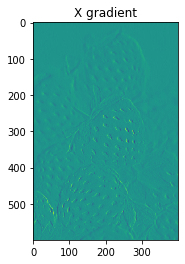

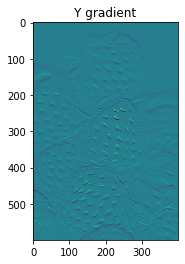

In [94]:
mag, theta = get_gradients(image)

In [95]:
HOG_hist = generate_HOG(mag,theta, image, patch_size=16)

In [96]:
HOG_hist.shape

(7600,)

In [97]:
print("The HOG vector is :", HOG_hist)

The HOG vector is : [1170.88083216   76.70259594 5150.16228173 ... 1970.47781957 4061.18721492
  125.65309291]
